# Data Processing

In [1]:
import os
import pandas as pd
import sys
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Directory path of the raw_data folder
directory = '../raw-data/acl_anthology/'

# List to store the dataframes for each JSON file
dataframes = []

# Recursively iterate over all subdirectories and files within the directory
for root, _, files in os.walk(directory):
    for file in files:
        if file.endswith('.jsonl'):  # Only process JSON files
            file_path = os.path.join(root, file)
            dataframe = pd.read_json(file_path, lines=True)
            dataframes.append(dataframe)

# Concatenate all dataframes into a single dataframe
combined_dataframe = pd.concat(dataframes, ignore_index=True)

In [4]:
combined_dataframe.head()

,Year,Venue,Acronym,Description,Abstract,Heading
0,2003,iwpt-2003,Supertagging,A Non-Statistical Parsing-Based Approach,We present a novel approach to supertagging w....,Supertagging: A Non-Statistical Parsing-Based ...
1,2020,iwltp-2020,CoBiLiRo,A Research Platform for Bimodal Corpora,This paper describes the on-going work carried...,CoBiLiRo: A Research Platform for Bimodal Corpora
2,2020,iwltp-2020,CLARIN,Distributed Language Resources and Technology ...,CLARIN is a European Research Infrastructure p...,CLARIN: Distributed Language Resources and Tec...
3,2020,iwltp-2020,ELRI,A Decentralised Network of National Relay Stat...,We describe the European Language Resource Inf...,ELRI: A Decentralised Network of National Rela...
4,2020,iwltp-2020,Eco.pangeamt,Industrializing Neural MT,Eco is Pangeanic’s customer portal for generic...,Eco.pangeamt: Industrializing Neural MT


In [5]:
len(combined_dataframe)

38784

## Data Cleaning

In [6]:
single_word_combined_dataframe = combined_dataframe

# replace all newline characters with spaces, and all "-\n" with empty string
single_word_combined_dataframe["Abstract"] = single_word_combined_dataframe["Abstract"].apply(lambda x: x.replace("-\n", ""))
single_word_combined_dataframe["Abstract"] = single_word_combined_dataframe["Abstract"].apply(lambda x: x.replace("\n", " "))
single_word_combined_dataframe["Description"] = single_word_combined_dataframe["Description"].apply(lambda x: x.replace("-\n", ""))
single_word_combined_dataframe["Description"] = single_word_combined_dataframe["Description"].apply(lambda x: x.replace("\n", " "))

# remove rows where the Description column contains colon
single_word_combined_dataframe = single_word_combined_dataframe[~single_word_combined_dataframe.Description.str.contains(":")]

# strip whitespace from all string columns
single_word_combined_dataframe = single_word_combined_dataframe.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# drop duplicates and rows with missing values
single_word_combined_dataframe = single_word_combined_dataframe.drop_duplicates(subset=['Acronym', 'Description', 'Abstract'])
single_word_combined_dataframe = single_word_combined_dataframe.dropna()
# also drop rows where the string columns are empty
single_word_combined_dataframe = single_word_combined_dataframe[(single_word_combined_dataframe != '').all(axis=1)]
print(len(single_word_combined_dataframe))

### Special processing for the Acronym column ###

# replace underscores with spaces in the Acronym column
single_word_combined_dataframe["Acronym"] = single_word_combined_dataframe["Acronym"].apply(lambda x: x.replace("_", " "))

# remove rows where the Acronym column contains more than one word
single_word_combined_dataframe = single_word_combined_dataframe[single_word_combined_dataframe.Acronym.str.split().apply(len)==1]
print(len(single_word_combined_dataframe))

# remove rows where the Acronym column contains characters other than letters and - (hyphen)
single_word_combined_dataframe = single_word_combined_dataframe[single_word_combined_dataframe.Acronym.str.match(r'^[a-zA-Z-]+$')]
print(len(single_word_combined_dataframe))

### Special processing for the Abstract column ###

# replace the first "abstract" string with empty string in the Abstract column.
single_word_combined_dataframe["Abstract"] = single_word_combined_dataframe["Abstract"].apply(lambda x: x.replace("Abstract", ""))

# remove strings after the last period in the Abstract column
single_word_combined_dataframe["Abstract"] = single_word_combined_dataframe["Abstract"].apply(lambda x: x[:x.rfind(".")]+".")

# if it is not English, remove the row
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
single_word_combined_dataframe = single_word_combined_dataframe[single_word_combined_dataframe.Abstract.apply(lambda x: detect(x) == "en")]
print(len(single_word_combined_dataframe))

# strip whitespace from all string columns
single_word_combined_dataframe = single_word_combined_dataframe.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

single_word_combined_dataframe.reset_index(drop=True, inplace=True)

21449
7616
6864


6803


## Outlier Detection

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-base")

In [8]:
# Get distributions of token lengths in acronyms, Descriptions, and abstracts

normalized_combined_dataframe = single_word_combined_dataframe
normalized_combined_dataframe["acronym_tok_len"] = normalized_combined_dataframe["Acronym"].apply(lambda x: len(tokenizer.tokenize(x)))   # tok level
normalized_combined_dataframe["acronym_len"] = normalized_combined_dataframe["Acronym"].apply(lambda x: len(x))   # char level
normalized_combined_dataframe["description_tok_len"] = normalized_combined_dataframe["Description"].apply(lambda x: len(tokenizer.tokenize(x)))   # tok level
normalized_combined_dataframe["abstract_tok_len"] = normalized_combined_dataframe["Abstract"].apply(lambda x: len(tokenizer.tokenize(x)))   # tok level
normalized_combined_dataframe["total_len"] = normalized_combined_dataframe["acronym_len"] + normalized_combined_dataframe["description_tok_len"] + normalized_combined_dataframe["abstract_tok_len"]

Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Remove outliers that are more than 3 standard deviations away from the mean
normalized_combined_dataframe = normalized_combined_dataframe[(normalized_combined_dataframe["acronym_len"] < normalized_combined_dataframe["acronym_len"].mean() + 3 * normalized_combined_dataframe["acronym_len"].std()) & (normalized_combined_dataframe["acronym_len"] > normalized_combined_dataframe["acronym_len"].mean() - 3 * normalized_combined_dataframe["acronym_len"].std())]
normalized_combined_dataframe = normalized_combined_dataframe[(normalized_combined_dataframe["description_tok_len"] < normalized_combined_dataframe["description_tok_len"].mean() + 3 * normalized_combined_dataframe["description_tok_len"].std()) & (normalized_combined_dataframe["description_tok_len"] > normalized_combined_dataframe["description_tok_len"].mean() - 3 * normalized_combined_dataframe["description_tok_len"].std())]
normalized_combined_dataframe = normalized_combined_dataframe[(normalized_combined_dataframe["abstract_tok_len"] < normalized_combined_dataframe["abstract_tok_len"].mean() + 3 * normalized_combined_dataframe["abstract_tok_len"].std()) & (normalized_combined_dataframe["abstract_tok_len"] > normalized_combined_dataframe["abstract_tok_len"].mean() - 3 * normalized_combined_dataframe["abstract_tok_len"].std())]

print(len(normalized_combined_dataframe))

6653


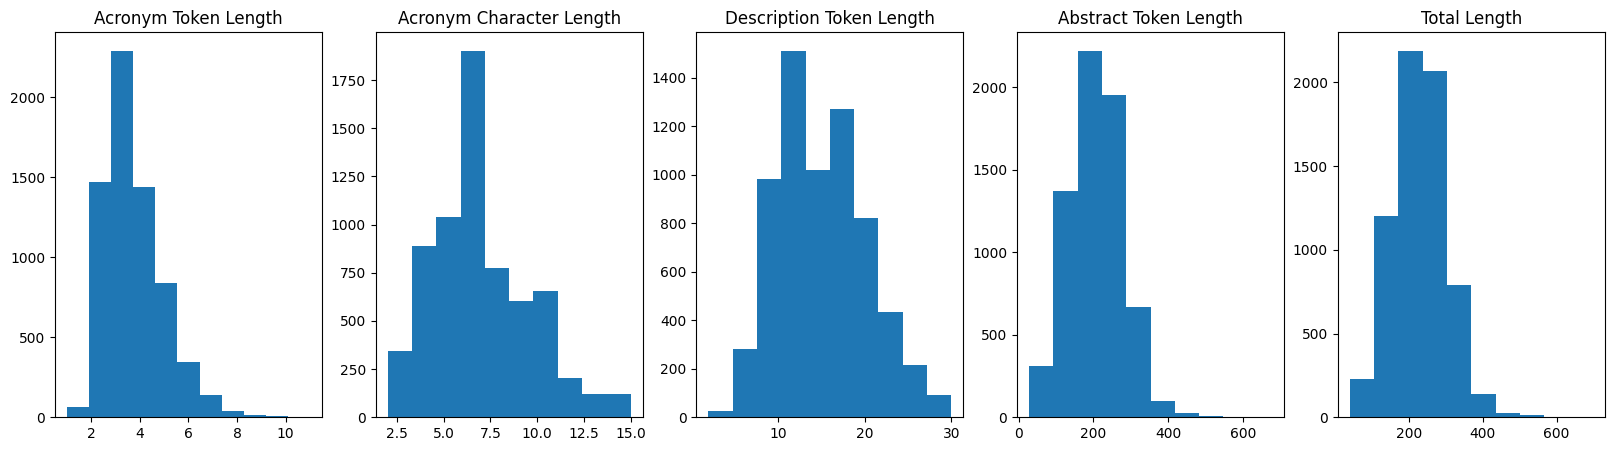

In [10]:
# plot the distributions

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].hist(normalized_combined_dataframe["acronym_tok_len"], bins=11)
ax[0].set_title("Acronym Token Length")
ax[1].hist(normalized_combined_dataframe["acronym_len"])
ax[1].set_title("Acronym Character Length")
ax[2].hist(normalized_combined_dataframe["description_tok_len"])
ax[2].set_title("Description Token Length")
ax[3].hist(normalized_combined_dataframe["abstract_tok_len"])
ax[3].set_title("Abstract Token Length")
ax[4].hist(normalized_combined_dataframe["total_len"])
ax[4].set_title("Total Length")
plt.show()

## Replace acronyms in the abstract with mask token

In [11]:
import re

def replace_with_mask(s):
    s["Abstract"] = s["Abstract"].replace(s["Acronym"], "<MASKED_ACRONYM>")
    return s["Abstract"]
        

masked_single_word_combined_dataframe = normalized_combined_dataframe
masked_single_word_combined_dataframe["Abstract"] = masked_single_word_combined_dataframe.apply(replace_with_mask, axis=1)

## Distribution of metrics of original short-title

In [12]:
from metrics.wordlikeness.wordlikeness import WordLikeness
from metrics.lcsratio.lcsratio import LCSRatio
from metrics.wordcoverage.wordcoverage import WordCoverage

In [13]:
wordlikeness = WordLikeness()
lcsratio = LCSRatio()
wordcoverage = WordCoverage()

In [14]:
def calculate_metrics(s):
    s["wordlikeness"] = wordlikeness.compute_score({0: [s.Description]}, {0: [s.Acronym]})[0]
    s["lcsratio"] = lcsratio.compute_score({0: [s.Description]}, {0: [s.Acronym]})[0]
    s["wordcoverage"] = wordcoverage.compute_score({0: [s.Description]}, {0: [s.Acronym]})[0]
    return s

In [15]:
masked_single_word_combined_dataframe = masked_single_word_combined_dataframe.apply(calculate_metrics, axis=1)

In [16]:
masked_single_word_combined_dataframe.wordlikeness.describe()

count    6653.000000
mean        0.675265
std         0.207710
min         0.100000
25%         0.555556
50%         0.714286
75%         0.818182
max         1.000000
Name: wordlikeness, dtype: float64

<Axes: >

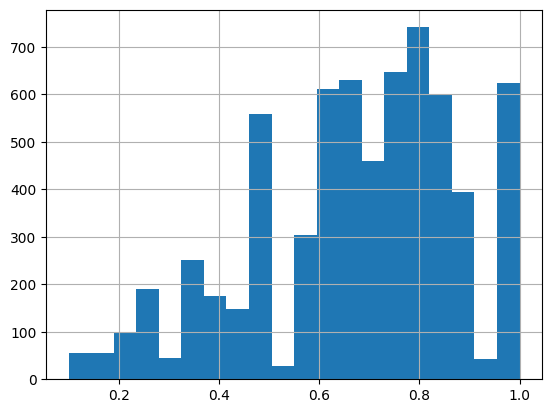

In [17]:
masked_single_word_combined_dataframe.wordlikeness.hist(bins=20)

In [18]:
masked_single_word_combined_dataframe.lcsratio.describe()

count    6653.000000
mean        0.839174
std         0.172080
min         0.000000
25%         0.714286
50%         0.857143
75%         1.000000
max         1.000000
Name: lcsratio, dtype: float64

<Axes: >

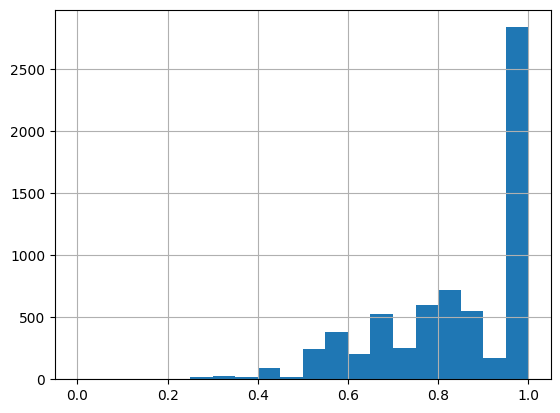

In [19]:
masked_single_word_combined_dataframe.lcsratio.hist(bins=20)

In [20]:
masked_single_word_combined_dataframe.wordcoverage.describe()

count    6653.000000
mean        0.795754
std         0.105701
min         0.526316
25%         0.727273
50%         0.800000
75%         0.857143
max         1.000000
Name: wordcoverage, dtype: float64

<Axes: >

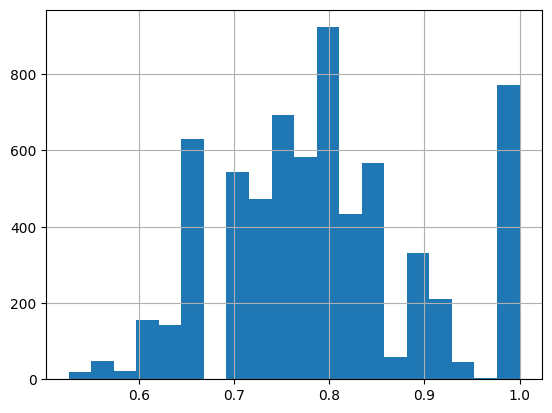

In [21]:
masked_single_word_combined_dataframe.wordcoverage.hist(bins=20)

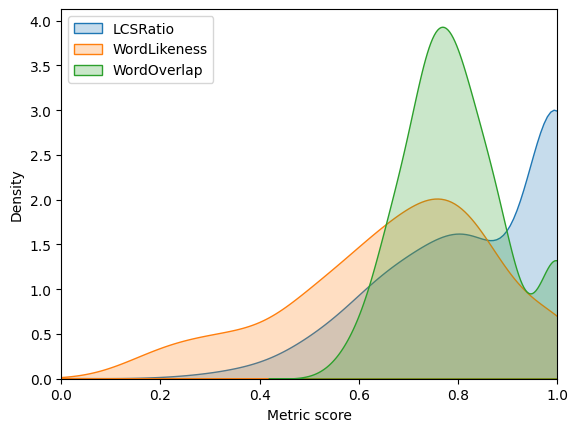

In [22]:
# draw kde plot, x-axis ranges from 0 to 1
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(masked_single_word_combined_dataframe.lcsratio, fill=True, bw_adjust=2)
sns.kdeplot(masked_single_word_combined_dataframe.wordlikeness, fill=True, bw_adjust=2)
sns.kdeplot(masked_single_word_combined_dataframe.wordcoverage, fill=True, bw_adjust=2)
plt.xlim(0, 1)
plt.legend(["LCSRatio", "WordLikeness", "WordOverlap"], loc="upper left")
plt.xlabel("Metric score")
plt.show()

In [23]:
filtered_dataframe = masked_single_word_combined_dataframe[(masked_single_word_combined_dataframe.wordcoverage >= 0.818182) & (masked_single_word_combined_dataframe.lcsratio == 1) & (masked_single_word_combined_dataframe.wordlikeness >= 0.857143)].reset_index(drop=True)

In [24]:
filtered_dataframe

,Year,Venue,Acronym,Description,Abstract,Heading,acronym_tok_len,acronym_len,description_tok_len,abstract_tok_len,total_len,wordlikeness,lcsratio,wordcoverage
0,2023,syntaxfest-2023,ICON,Building a Large-Scale Benchmark Constituency ...,Constituency parsing is an important task of i...,ICON: Building a Large-Scale Benchmark Constit...,2,4,19,234,257,1.000000,1.0,1.000000
1,2014,bea-2014,ArCADE,An Arabic Corpus of Auditory Dictation Errors,We present a new corpus of word-level listenin...,ArCADE: An Arabic Corpus of Auditory Dictation...,3,6,14,129,149,1.000000,1.0,1.000000
2,2007,acl-2007,PERSONAGE,Personality Generation for Dialogue,"Over the last ﬁfty years, the “Big Five” model...",PERSONAGE: Personality Generation for Dialogue,4,9,6,162,177,0.888889,1.0,0.875000
3,2012,acl-2012,PORT,a Precision-Order-Recall MT Evaluation Metric ...,Many machine translation (MT) evaluation metr...,PORT: a Precision-Order-Recall MT Evaluation M...,2,4,17,240,261,1.000000,1.0,1.000000
4,2012,acl-2012,FLOW,A First-Language-Oriented Writing Assistant Sy...,Writing in English might be one of the most d...,FLOW: A First-Language-Oriented Writing Assist...,2,4,14,110,128,1.000000,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,2022,acl-2022,ePiC,Employing Proverbs in Context as a Benchmark f...,While large language models have shown excitin...,ePiC: Employing Proverbs in Context as a Bench...,5,4,17,176,197,1.000000,1.0,1.000000
466,2022,acl-2022,SPoT,Better Frozen Model Adaptation through Soft Pr...,There has been growing interest in parameter-e...,SPoT: Better Frozen Model Adaptation through S...,3,4,14,277,295,1.000000,1.0,1.000000
467,2022,acl-2022,RoMe,A Robust Metric for Evaluating Natural Languag...,Evaluating Natural Language Generation (NLG) s...,RoMe: A Robust Metric for Evaluating Natural L...,3,4,13,232,249,1.000000,1.0,1.000000
468,2022,acl-2022,ASPECTNEWS,Aspect-Oriented Summarization of News Documents,Generic summaries try to cover an entire docum...,ASPECTNEWS: Aspect-Oriented Summarization of N...,5,10,13,264,287,0.900000,1.0,0.823529


## Save the data

In [27]:
output_dataframe = masked_single_word_combined_dataframe[['Year', 'Venue', 'Acronym', 'Description', 'Abstract', 'wordlikeness', 'lcsratio', 'wordcoverage']].reset_index(drop=True)
filtered_dataframe = filtered_dataframe[['Year', 'Venue', 'Acronym', 'Description', 'Abstract', 'wordlikeness', 'lcsratio', 'wordcoverage']].reset_index(drop=True)
output_dataframe.to_json("../data/single_word_with_replacement.jsonl", orient="records", lines=True)
filtered_dataframe.to_json("../data/single_word_with_replacement_filtered.jsonl", orient="records", lines=True)

In [28]:
masked_single_word_combined_dataframe

,Year,Venue,Acronym,Description,Abstract,Heading,acronym_tok_len,acronym_len,description_tok_len,abstract_tok_len,total_len,wordlikeness,lcsratio,wordcoverage
0,2003,iwpt-2003,Supertagging,A Non-Statistical Parsing-Based Approach,We present a novel approach to supertagging w....,Supertagging: A Non-Statistical Parsing-Based ...,3,12,10,161,183,0.833333,0.500000,0.736842
1,2020,iwltp-2020,CoBiLiRo,A Research Platform for Bimodal Corpora,This paper describes the on-going work carried...,CoBiLiRo: A Research Platform for Bimodal Corpora,7,8,9,246,263,0.500000,0.875000,0.666667
2,2020,iwltp-2020,CLARIN,Distributed Language Resources and Technology ...,<MASKED_ACRONYM> is a European Research Infras...,CLARIN: Distributed Language Resources and Tec...,3,6,11,183,200,0.833333,1.000000,0.857143
3,2020,iwltp-2020,ELRI,A Decentralised Network of National Relay Stat...,We describe the European Language Resource Inf...,ELRI: A Decentralised Network of National Rela...,3,4,20,140,164,0.250000,1.000000,0.857143
4,2013,law-2013,Entailment,An Effective Metric for Comparing and Evaluati...,Hierarchical or nested annotation of linguisti...,Entailment: An Effective Metric for Comparing ...,3,10,25,134,169,0.800000,0.900000,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,2022,acl-2022,SocioFillmore,A Tool for Discovering Perspectives,SOCIOFILLMORE is a multilingual tool which hel...,SocioFillmore: A Tool for Discovering Perspect...,5,13,7,143,163,0.846154,0.538462,0.636364
6798,2022,acl-2022,TimeLMs,Diachronic Language Models from Twitter,"Despite its importance, the time variable has ...",TimeLMs: Diachronic Language Models from Twitter,3,7,8,152,167,0.571429,0.714286,0.833333
6799,2022,acl-2022,Adaptor,Objective-Centric Adaptation Framework for Lan...,This paper introduces <MASKED_ACRONYM> library...,Adaptor: Objective-Centric Adaptation Framewor...,3,7,13,119,139,0.857143,1.000000,0.857143
6800,2022,acl-2022,QuickGraph,A Rapid Annotation Tool for Knowledge Graph Ex...,Acquiring high-quality annotated corpora for c...,QuickGraph: A Rapid Annotation Tool for Knowle...,2,10,15,178,203,0.900000,0.700000,0.705882


In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_test_data = train_test_split(output_dataframe, random_state=42, test_size=1653)
val_data, test_data = train_test_split(val_test_data, random_state=42, test_size=1000)

In [ ]:
train_data.to_json("../data/single_word_with_replacement_train.jsonl", lines=True, orient="records")
val_data.to_json("../data/single_word_with_replacement_val.jsonl", lines=True, orient="records")
test_data.to_json("../data/single_word_with_replacement_test.jsonl", lines=True, orient="records")